# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h        snow_1h  \
count   341988.000000  341988.000000  341988.000000  341988.000000   
mean      3223.797936     282.704303       0.086439       0.000249   
std       1943.974204      12.922822       0.321004       0.000466   
min         41.627638     250.083873       0.000008       0.000000   
25%       1152.987320     270.511312       0.000130       0.000002   
50%       3608.409516     285.328962       0.000575       0.000006   
75%       5010.047921     293.711888       0.037928       0.000324   
max       7076.619110     305.881726      12.279954       0.004205   

          clouds_all  
count  341988.000000  
mean       39.871618  
std        39.339560  
min         0.016394  
25%         4.172619  
50%        15.465574  
75%        87.893841  
max        97.951007  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511

In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341988.000000,341988.000000,341988.000000,341988.000000,341988.000000
mean,3223.797936,282.704303,0.086439,0.000249,39.871618
std,1943.974204,12.922822,0.321004,0.000466,39.339560
min,41.627638,250.083873,0.000008,0.000000,0.016394
25%,1152.987320,270.511312,0.000130,0.000002,4.172619
50%,3608.409516,285.328962,0.000575,0.000006,15.465574
75%,5010.047921,293.711888,0.037928,0.000324,87.893841
max,7076.619110,305.881726,12.279954,0.004205,97.951007


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.10515984726696162 // Train Acc: 0.00438288920056101
Val Loss: 0.07004647844293144 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012600180642028844 // Train Acc: 0.00438288920056101
Val Loss: 0.01017602317275877 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008331272913388605 // Train Acc: 0.00438288920056101
Val Loss: 0.005578658378714424 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007655185921937958 // Train Acc: 0.00438288920056101
Val Loss: 0.0047750689214869834 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007391368834756388 // Train Acc: 0.00438288920056101
Val Loss: 0.0044325248814407695 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007258904082269564 // Train Acc: 0.00438288920056101
Val Loss: 0.004273637135125948 // Val Acc: 0.0
***

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:28<31:14, 208.33s/it]

Epoch: 1
Train Loss: 0.24972523144886505 // Train Acc: 0.00876577840112202
Val Loss: 0.09940804959682936 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014646229838043305 // Train Acc: 0.00438288920056101
Val Loss: 0.01263921878436643 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009677132548500495 // Train Acc: 0.00438288920056101
Val Loss: 0.006960674097468512 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007762723988663995 // Train Acc: 0.00438288920056101
Val Loss: 0.0047564078109297026 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007447382087099561 // Train Acc: 0.00438288920056101
Val Loss: 0.004457639784060335 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007331885613284243 // Train Acc: 0.00438288920056101
Val Loss: 0.004336385297055325 // Val Acc: 0.0
****

 20%|██        | 2/10 [06:58<27:55, 209.48s/it]

Epoch: 1
Train Loss: 0.0737100598071852 // Train Acc: 0.00438288920056101
Val Loss: 0.05905069151286329 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010062568189137384 // Train Acc: 0.00438288920056101
Val Loss: 0.007700531474011165 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008245975124619661 // Train Acc: 0.00438288920056101
Val Loss: 0.0056590108656104695 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0076353546113773745 // Train Acc: 0.00438288920056101
Val Loss: 0.00483975178572569 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007313146938401344 // Train Acc: 0.00438288920056101
Val Loss: 0.004365951696599132 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0071758632975934804 // Train Acc: 0.00438288920056101
Val Loss: 0.0041378967076791135 // Val Acc: 0.0
**

 30%|███       | 3/10 [10:28<24:28, 209.73s/it]

Epoch: 1
Train Loss: 0.6006223210362198 // Train Acc: 0.00876577840112202
Val Loss: 0.30284402996636506 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01720523116927265 // Train Acc: 0.00438288920056101
Val Loss: 0.014635962486434518 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011292385275059002 // Train Acc: 0.00438288920056101
Val Loss: 0.008910159135676837 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008827433095876582 // Train Acc: 0.00438288920056101
Val Loss: 0.006029243545679982 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007850634829542204 // Train Acc: 0.00438288920056101
Val Loss: 0.004794509529418657 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007489078180527453 // Train Acc: 0.00438288920056101
Val Loss: 0.0043709307772975955 // Val Acc: 0.0
*****

 40%|████      | 4/10 [13:58<20:57, 209.66s/it]

Epoch: 1
Train Loss: 0.12664695685470756 // Train Acc: 0.00438288920056101
Val Loss: 0.07319784746243713 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012940947134256739 // Train Acc: 0.00438288920056101
Val Loss: 0.010930525110197369 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009011019608410805 // Train Acc: 0.00438288920056101
Val Loss: 0.006255278573109863 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008268260355545063 // Train Acc: 0.00438288920056101
Val Loss: 0.005318867425915649 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007784375686754916 // Train Acc: 0.00438288920056101
Val Loss: 0.004709727205388415 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0075347490786988845 // Train Acc: 0.00438288920056101
Val Loss: 0.004407438602601963 // Val Acc: 0.0
***

 50%|█████     | 5/10 [17:24<17:22, 208.54s/it]

Epoch: 1
Train Loss: 0.11513434524476779 // Train Acc: 0.00438288920056101
Val Loss: 0.07395462737826819 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011522162827789825 // Train Acc: 0.00438288920056101
Val Loss: 0.008824921914198425 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00816559228264997 // Train Acc: 0.00438288920056101
Val Loss: 0.005588004232143585 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0076302522669322945 // Train Acc: 0.00438288920056101
Val Loss: 0.004995318838614929 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007389540270396716 // Train Acc: 0.00438288920056101
Val Loss: 0.004644013627359037 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0072328648686691135 // Train Acc: 0.00438288920056101
Val Loss: 0.0043885954551063895 // Val Acc: 0.0
**

 60%|██████    | 6/10 [19:45<12:22, 185.55s/it]

INFO: Validation loss did not improve in epoch 136
Early stopping after 136 epochs
Epoch: 1
Train Loss: 0.10341412824321261 // Train Acc: 0.00438288920056101
Val Loss: 0.07421286630161693 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011098055830578024 // Train Acc: 0.00438288920056101
Val Loss: 0.00862685424861697 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008414443583276024 // Train Acc: 0.00438288920056101
Val Loss: 0.00523615576813437 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007841166788072104 // Train Acc: 0.00438288920056101
Val Loss: 0.0045945422927943175 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007511491461122751 // Train Acc: 0.00438288920056101
Val Loss: 0.004352250165211853 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007347870853874535 // 

 70%|███████   | 7/10 [23:12<09:37, 192.55s/it]

Epoch: 1
Train Loss: 0.1793283150592743 // Train Acc: 0.00438288920056101
Val Loss: 0.08798150358240256 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010409239016677061 // Train Acc: 0.00438288920056101
Val Loss: 0.007973839259402973 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.007952930706489158 // Train Acc: 0.00438288920056101
Val Loss: 0.005417423063805432 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007328862057728393 // Train Acc: 0.00438288920056101
Val Loss: 0.004531479856585351 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00700591279335482 // Train Acc: 0.00438288920056101
Val Loss: 0.004082277608156371 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006813953163658712 // Train Acc: 0.00438288920056101
Val Loss: 0.0038808711511449196 // Val Acc: 0.0
*****

 80%|████████  | 8/10 [26:40<06:34, 197.27s/it]

Epoch: 1
Train Loss: 0.2711561115152956 // Train Acc: 0.00876577840112202
Val Loss: 0.08026092821794949 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014096716987060548 // Train Acc: 0.00438288920056101
Val Loss: 0.01184099898255022 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010138520195709246 // Train Acc: 0.00438288920056101
Val Loss: 0.007815146010389991 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008857982572126314 // Train Acc: 0.00438288920056101
Val Loss: 0.006197971519438571 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007997564122415191 // Train Acc: 0.00438288920056101
Val Loss: 0.005090593211248182 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0076130582692381125 // Train Acc: 0.00438288920056101
Val Loss: 0.004553544652920342 // Val Acc: 0.0
*****

 90%|█████████ | 9/10 [30:07<03:20, 200.40s/it]

Epoch: 1
Train Loss: 0.17925598075793636 // Train Acc: 0.013148667601683029
Val Loss: 0.06713880075330145 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011175247068290936 // Train Acc: 0.00438288920056101
Val Loss: 0.008682393270094744 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.007827009135781465 // Train Acc: 0.00438288920056101
Val Loss: 0.004814455778798445 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007247283895399427 // Train Acc: 0.00438288920056101
Val Loss: 0.004113210830837488 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007103985967049258 // Train Acc: 0.00438288920056101
Val Loss: 0.0039449654051280595 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0070172249967151365 // Train Acc: 0.00438288920056101
Val Loss: 0.0038626040593626792 // Val Acc: 0.0


100%|██████████| 10/10 [33:34<00:00, 201.45s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.36083984488900883 // Train Acc: 0.00876577840112202
Val Loss: 0.1492760960807961 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013024580565661317 // Train Acc: 0.00438288920056101
Val Loss: 0.011479961505327164 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008369592116717223 // Train Acc: 0.00438288920056101
Val Loss: 0.006399473821576894 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007511319764687315 // Train Acc: 0.00438288920056101
Val Loss: 0.0052348470179301295 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007240891779562639 // Train Acc: 0.00438288920056101
Val Loss: 0.004828004348301067 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007115675378910842 // Train Acc: 0.00438288920056101
Val Loss: 0.0046592976229547865 // Val Acc: 0.0
***

 10%|█         | 1/10 [03:27<31:08, 207.60s/it]

Epoch: 1
Train Loss: 0.0659167825088929 // Train Acc: 0.00438288920056101
Val Loss: 0.06184769199972742 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010571416326684858 // Train Acc: 0.00438288920056101
Val Loss: 0.008593020396924505 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0077572047349906735 // Train Acc: 0.00438288920056101
Val Loss: 0.005722505075783793 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007226626908434046 // Train Acc: 0.00438288920056101
Val Loss: 0.004993353206455038 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007054766620310783 // Train Acc: 0.00438288920056101
Val Loss: 0.004696127395485685 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00697087645899703 // Train Acc: 0.00438288920056101
Val Loss: 0.0045541852923225235 // Val Acc: 0.0
****

 20%|██        | 2/10 [06:55<27:43, 207.98s/it]

Epoch: 1
Train Loss: 0.30809992883056614 // Train Acc: 0.00438288920056101
Val Loss: 0.17279894796482634 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014202289190535207 // Train Acc: 0.00438288920056101
Val Loss: 0.012563367193732201 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008851951642254522 // Train Acc: 0.00438288920056101
Val Loss: 0.006446915016813057 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007652947538092127 // Train Acc: 0.00438288920056101
Val Loss: 0.005231452701623771 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007178661472269897 // Train Acc: 0.00438288920056101
Val Loss: 0.004872348156935546 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006731591727205802 // Train Acc: 0.00438288920056101
Val Loss: 0.004495074737063619 // Val Acc: 0.0
****

 30%|███       | 3/10 [10:24<24:16, 208.06s/it]

Epoch: 1
Train Loss: 0.08673543490856092 // Train Acc: 0.00438288920056101
Val Loss: 0.06884225541621111 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013127351040281825 // Train Acc: 0.00438288920056101
Val Loss: 0.011606565456879273 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009397676875514368 // Train Acc: 0.00438288920056101
Val Loss: 0.00733743198058997 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008254177021293746 // Train Acc: 0.00438288920056101
Val Loss: 0.006004140123704009 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007675633604767592 // Train Acc: 0.00438288920056101
Val Loss: 0.005323072797304877 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007397437858399197 // Train Acc: 0.00438288920056101
Val Loss: 0.004991905077025713 // Val Acc: 0.0
*****

 40%|████      | 4/10 [13:51<20:47, 208.00s/it]

Epoch: 1
Train Loss: 0.1072951902806508 // Train Acc: 0.00438288920056101
Val Loss: 0.08237230660540334 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012350226049069811 // Train Acc: 0.00438288920056101
Val Loss: 0.010558081627300198 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008697633074105392 // Train Acc: 0.00438288920056101
Val Loss: 0.006995484123027392 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008059385369125581 // Train Acc: 0.00438288920056101
Val Loss: 0.0061904067589556066 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0076552389663426 // Train Acc: 0.00438288920056101
Val Loss: 0.005643262287204185 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007442263717015978 // Train Acc: 0.00438288920056101
Val Loss: 0.005308414313659658 // Val Acc: 0.0
******

 50%|█████     | 5/10 [17:19<17:20, 208.01s/it]

Epoch: 1
Train Loss: 0.22588995746944263 // Train Acc: 0.00438288920056101
Val Loss: 0.08500664946989397 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.015683275661829643 // Train Acc: 0.00438288920056101
Val Loss: 0.013959515630529168 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010054335785444518 // Train Acc: 0.00438288920056101
Val Loss: 0.008195072710723355 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008337233298187774 // Train Acc: 0.00438288920056101
Val Loss: 0.006182907787517885 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007713743480285538 // Train Acc: 0.00438288920056101
Val Loss: 0.005475852927559296 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007532367563765982 // Train Acc: 0.00438288920056101
Val Loss: 0.0052281013778881745 // Val Acc: 0.0
***

 60%|██████    | 6/10 [20:49<13:53, 208.46s/it]

Epoch: 1
Train Loss: 0.07077142237822773 // Train Acc: 0.00438288920056101
Val Loss: 0.06545880583397458 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01420034644217459 // Train Acc: 0.00438288920056101
Val Loss: 0.01287387821593144 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010232979122831436 // Train Acc: 0.00438288920056101
Val Loss: 0.008306735735438931 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008428097907310092 // Train Acc: 0.00438288920056101
Val Loss: 0.006510636890882605 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007854243179098774 // Train Acc: 0.00438288920056101
Val Loss: 0.005829967496906187 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007591540209732187 // Train Acc: 0.00438288920056101
Val Loss: 0.005456993106511955 // Val Acc: 0.0
******

 70%|███████   | 7/10 [24:17<10:24, 208.30s/it]

Epoch: 1
Train Loss: 0.11582693880813152 // Train Acc: 0.00438288920056101
Val Loss: 0.056727053702212454 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011434377027743432 // Train Acc: 0.00438288920056101
Val Loss: 0.00955109127399543 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008081540525113695 // Train Acc: 0.00438288920056101
Val Loss: 0.005659126183488981 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007412785654730813 // Train Acc: 0.00438288920056101
Val Loss: 0.004837001188595392 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007211852939061424 // Train Acc: 0.00438288920056101
Val Loss: 0.004579441182399064 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0071133494633151976 // Train Acc: 0.00438288920056101
Val Loss: 0.004449926043358328 // Val Acc: 0.0
***

 80%|████████  | 8/10 [27:45<06:56, 208.14s/it]

Epoch: 1
Train Loss: 0.22302874985972596 // Train Acc: 0.0
Val Loss: 0.09422475543249859 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.016817406051090774 // Train Acc: 0.00438288920056101
Val Loss: 0.015064375553531259 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010750022766782497 // Train Acc: 0.00438288920056101
Val Loss: 0.009022144562815934 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009323797638032998 // Train Acc: 0.00438288920056101
Val Loss: 0.007438484799074992 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008534511753395826 // Train Acc: 0.00438288920056101
Val Loss: 0.006531981042366517 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008113014865745 // Train Acc: 0.00438288920056101
Val Loss: 0.00599547141634472 // Val Acc: 0.0
************************

 90%|█████████ | 9/10 [31:12<03:27, 207.94s/it]

Epoch: 1
Train Loss: 0.19733294939718943 // Train Acc: 0.0
Val Loss: 0.10309122927654325 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0135698996087194 // Train Acc: 0.00438288920056101
Val Loss: 0.01170158512194463 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009070287657794536 // Train Acc: 0.00438288920056101
Val Loss: 0.007493782372559222 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008239126365846037 // Train Acc: 0.00438288920056101
Val Loss: 0.006517489506141021 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007800114522968925 // Train Acc: 0.00438288920056101
Val Loss: 0.005919737095180689 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007481886555609224 // Train Acc: 0.00438288920056101
Val Loss: 0.005457660042042478 // Val Acc: 0.0
***********************

100%|██████████| 10/10 [34:40<00:00, 208.04s/it]


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.3730831634237589 // Train Acc: 0.0
Val Loss: 0.16536371268373629 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.006128286083031649 // Train Acc: 0.0
Val Loss: 0.006138352653812929 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002813454236633433 // Train Acc: 0.0
Val Loss: 0.0028450383285096945 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0019182945605070913 // Train Acc: 0.0
Val Loss: 0.001996855216533955 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0017223784557251758 // Train Acc: 0.0
Val Loss: 0.0018333321015803175 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016421774465693252 // Train Acc: 0.0
Val Loss: 0.001754972788631427 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015792156121101515 /

 10%|█         | 1/10 [03:28<31:13, 208.14s/it]

Epoch: 1
Train Loss: 0.16549496817680762 // Train Acc: 0.0
Val Loss: 0.07805581001679325 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004570213657722849 // Train Acc: 0.0
Val Loss: 0.00453481424272102 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0025632169025330996 // Train Acc: 0.0
Val Loss: 0.0026145934380263133 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0020921304110495757 // Train Acc: 0.0
Val Loss: 0.002143154316516749 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001823553274307912 // Train Acc: 0.0
Val Loss: 0.0018910038004975307 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016546311148752226 // Train Acc: 0.0
Val Loss: 0.0017454869746504997 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015793794487561537 

 20%|██        | 2/10 [06:56<27:45, 208.20s/it]

Epoch: 1
Train Loss: 0.19576682284119085 // Train Acc: 0.0
Val Loss: 0.10934193813184787 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004194317445149815 // Train Acc: 0.0
Val Loss: 0.004065187229754081 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002484354794402261 // Train Acc: 0.0
Val Loss: 0.002542361409947089 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0021073830767967677 // Train Acc: 0.0
Val Loss: 0.00216430973527594 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0017827360297381475 // Train Acc: 0.0
Val Loss: 0.0018575406573483897 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016187890890762367 // Train Acc: 0.0
Val Loss: 0.0017215178493480588 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.001554409160987679 //

 30%|███       | 3/10 [10:26<24:23, 209.04s/it]

Epoch: 1
Train Loss: 0.09041071140833021 // Train Acc: 0.0
Val Loss: 0.060885900475459394 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004601037515089605 // Train Acc: 0.0
Val Loss: 0.004652951652178926 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0024911715578206854 // Train Acc: 0.0
Val Loss: 0.002540798360278944 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0019060963030292576 // Train Acc: 0.0
Val Loss: 0.001977369382420773 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00166153890721769 // Train Acc: 0.0
Val Loss: 0.0017620488619509897 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015666240079346052 // Train Acc: 0.0
Val Loss: 0.0016768147434659468 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.001517602243733548 /

 40%|████      | 4/10 [13:59<21:04, 210.77s/it]

Epoch: 1
Train Loss: 0.08477806583109611 // Train Acc: 0.0
Val Loss: 0.0741716956085 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0067579839822704295 // Train Acc: 0.0
Val Loss: 0.006635627025145226 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00259477933645895 // Train Acc: 0.0
Val Loss: 0.002631721244513593 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0019754646283928383 // Train Acc: 0.0
Val Loss: 0.0020571337507480974 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001787067482983994 // Train Acc: 0.0
Val Loss: 0.0018957130773208889 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016752546205777063 // Train Acc: 0.0
Val Loss: 0.0017893402820957731 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015992879795141096 // T

 50%|█████     | 5/10 [17:28<17:29, 209.97s/it]

Epoch: 1
Train Loss: 0.12063259494505289 // Train Acc: 0.0
Val Loss: 0.07946909691451648 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005211687848614568 // Train Acc: 0.0
Val Loss: 0.005236481364514658 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0034024199501246862 // Train Acc: 0.0
Val Loss: 0.0034932720399456483 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0020564538625893174 // Train Acc: 0.0
Val Loss: 0.0020907958523973865 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0016469307651849096 // Train Acc: 0.0
Val Loss: 0.0017465083388671508 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015604683784152438 // Train Acc: 0.0
Val Loss: 0.00167021001281845 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015141462576480878

 60%|██████    | 6/10 [20:56<13:57, 209.40s/it]

Epoch: 1
Train Loss: 0.06588022207624447 // Train Acc: 0.0
Val Loss: 0.05843751428014073 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0033428350159490864 // Train Acc: 0.0
Val Loss: 0.0033489038384722433 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0021356874141322257 // Train Acc: 0.0
Val Loss: 0.002192978209662433 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0017040490109452569 // Train Acc: 0.0
Val Loss: 0.0017935533412925992 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001541473768712877 // Train Acc: 0.0
Val Loss: 0.0016528776222963521 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.001484023800187027 // Train Acc: 0.0
Val Loss: 0.0016014155618457497 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.001449165238475043

 70%|███████   | 7/10 [24:24<10:27, 209.02s/it]

Epoch: 1
Train Loss: 0.3051343880290738 // Train Acc: 0.0
Val Loss: 0.18151299455645364 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004838558178568758 // Train Acc: 0.0
Val Loss: 0.004807143518961342 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002345402993588038 // Train Acc: 0.0
Val Loss: 0.0024000211484215155 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0017247054798787834 // Train Acc: 0.0
Val Loss: 0.0018222935015840362 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001583059243440692 // Train Acc: 0.0
Val Loss: 0.0016988522286803915 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015207650990388324 // Train Acc: 0.0
Val Loss: 0.0016406235239090003 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.001482174051871659 /

 80%|████████  | 8/10 [27:53<06:57, 208.78s/it]

Epoch: 1
Train Loss: 0.3512288974428244 // Train Acc: 0.0
Val Loss: 0.18317651053547193 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004881501203692854 // Train Acc: 0.0
Val Loss: 0.004832428148375335 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0024475554199180688 // Train Acc: 0.0
Val Loss: 0.002470015643122892 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0019319839761275694 // Train Acc: 0.0
Val Loss: 0.002005307755514969 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001756861686684011 // Train Acc: 0.0
Val Loss: 0.0018545667438926538 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016756270523362652 // Train Acc: 0.0
Val Loss: 0.001776951651008248 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0016205800125907014 //

 90%|█████████ | 9/10 [31:22<03:28, 208.81s/it]

Epoch: 1
Train Loss: 0.3734751645094215 // Train Acc: 0.0
Val Loss: 0.1382077701348166 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005930880994404056 // Train Acc: 0.0
Val Loss: 0.00602853924358607 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.003052767348292233 // Train Acc: 0.0
Val Loss: 0.003140617760324944 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0020809177429935155 // Train Acc: 0.0
Val Loss: 0.0021474380446103655 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0017315931168798264 // Train Acc: 0.0
Val Loss: 0.0018116335131555753 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015526780277212394 // Train Acc: 0.0
Val Loss: 0.0016501158541400121 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0014772086379895128 //

100%|██████████| 10/10 [34:50<00:00, 209.09s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.18549370820194322 // Train Acc: 0.002805206463195691
Val Loss: 0.059284891158844645 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.007258394578355991 // Train Acc: 0.002805206463195691
Val Loss: 0.00554346569501167 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005917996128321302 // Train Acc: 0.002805206463195691
Val Loss: 0.0044998849942898276 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005422893410199113 // Train Acc: 0.002805206463195691
Val Loss: 0.004098353893731543 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005259847176108464 // Train Acc: 0.002805206463195691
Val Loss: 0.003963677822141333 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005159284718568968 // Train Acc: 0.002805206463195691
Val Loss: 0.003909628478590441 // Val Acc: 0

 10%|█         | 1/10 [01:51<16:43, 111.54s/it]

INFO: Validation loss did not improve in epoch 71
Early stopping after 71 epochs
Epoch: 1
Train Loss: 0.08405677054271343 // Train Acc: 0.002805206463195691
Val Loss: 0.059310024708844306 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008697130294547824 // Train Acc: 0.002805206463195691
Val Loss: 0.006204514265887104 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006147643565442714 // Train Acc: 0.002805206463195691
Val Loss: 0.0038518838818561744 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005800229154696063 // Train Acc: 0.002805206463195691
Val Loss: 0.003678685046988801 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005658133032867983 // Train Acc: 0.002805206463195691
Val Loss: 0.003622164406285234 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0055650465453860

 20%|██        | 2/10 [07:09<31:05, 233.19s/it]

Epoch: 1
Train Loss: 0.11076287711557516 // Train Acc: 0.002805206463195691
Val Loss: 0.060539816432956896 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.007147233118041865 // Train Acc: 0.002805206463195691
Val Loss: 0.004710343475728244 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006014285805955767 // Train Acc: 0.002805206463195691
Val Loss: 0.00370672270864918 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005749216816778699 // Train Acc: 0.002805206463195691
Val Loss: 0.0036243155845205478 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0056463876999668025 // Train Acc: 0.002805206463195691
Val Loss: 0.0035900056065881645 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005603005669171265 // Train Acc: 0.002805206463195691
Val Loss: 0.003571033682164035 // Val Acc:

 30%|███       | 3/10 [12:28<31:44, 272.09s/it]

Epoch: 1
Train Loss: 0.42907494598501356 // Train Acc: 0.005610412926391382
Val Loss: 0.18909081632501623 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.00783438058750816 // Train Acc: 0.002805206463195691
Val Loss: 0.005951127947799945 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0063097179362373145 // Train Acc: 0.002805206463195691
Val Loss: 0.004532510023616421 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005925091109748535 // Train Acc: 0.002805206463195691
Val Loss: 0.004114749676579338 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005798298791255735 // Train Acc: 0.002805206463195691
Val Loss: 0.0039117603815877495 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005723888571618653 // Train Acc: 0.002805206463195691
Val Loss: 0.0037694120344057094 // Val Acc: 

 40%|████      | 4/10 [17:10<27:35, 275.96s/it]

INFO: Validation loss did not improve in epoch 177
Early stopping after 177 epochs
Epoch: 1
Train Loss: 0.17576876543863565 // Train Acc: 0.002805206463195691
Val Loss: 0.08713211330553788 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008534558102602634 // Train Acc: 0.005610412926391382
Val Loss: 0.006072121478742763 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006156078971173326 // Train Acc: 0.002805206463195691
Val Loss: 0.004386719208985065 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005795298759372825 // Train Acc: 0.002805206463195691
Val Loss: 0.004031240573843543 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005643170382125267 // Train Acc: 0.002805206463195691
Val Loss: 0.0038552842903463694 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005560433822343

 50%|█████     | 5/10 [22:28<24:15, 291.09s/it]

Epoch: 1
Train Loss: 0.07692923176117389 // Train Acc: 0.002805206463195691
Val Loss: 0.06785827324715223 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0070328787188116745 // Train Acc: 0.002805206463195691
Val Loss: 0.005477520654218669 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005965473209662426 // Train Acc: 0.002805206463195691
Val Loss: 0.004413882499688901 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0057122396240464396 // Train Acc: 0.002805206463195691
Val Loss: 0.003988753201432128 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005604892899689835 // Train Acc: 0.002805206463195691
Val Loss: 0.0037886405617438175 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005539442230094578 // Train Acc: 0.002805206463195691
Val Loss: 0.0036772178552045456 // Val Acc

 60%|██████    | 6/10 [27:46<20:01, 300.31s/it]

Epoch: 1
Train Loss: 0.12984911575779667 // Train Acc: 0.002805206463195691
Val Loss: 0.07238459358975459 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.007694606992681101 // Train Acc: 0.002805206463195691
Val Loss: 0.0055162012930226965 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006189034366499486 // Train Acc: 0.002805206463195691
Val Loss: 0.004341132034027028 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005839594936022774 // Train Acc: 0.002805206463195691
Val Loss: 0.003925996787749294 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005701642800506022 // Train Acc: 0.002805206463195691
Val Loss: 0.0037172285547568936 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005621874617776144 // Train Acc: 0.002805206463195691
Val Loss: 0.003601618371760012 // Val Acc: 

 70%|███████   | 7/10 [33:04<15:18, 306.17s/it]

Epoch: 1
Train Loss: 0.069261833774578 // Train Acc: 0.002805206463195691
Val Loss: 0.05611003230043342 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0068940577373958626 // Train Acc: 0.002805206463195691
Val Loss: 0.005286344583407881 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005831653829618011 // Train Acc: 0.002805206463195691
Val Loss: 0.004166366497454955 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005591094122622313 // Train Acc: 0.002805206463195691
Val Loss: 0.0037586954235899776 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005497113555044653 // Train Acc: 0.002805206463195691
Val Loss: 0.0035928735330313694 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005432059934195148 // Train Acc: 0.002805206463195691
Val Loss: 0.0035165403449641057 // Val Acc: 

 80%|████████  | 8/10 [38:23<10:20, 310.19s/it]

Epoch: 1
Train Loss: 0.13758536503120214 // Train Acc: 0.002805206463195691
Val Loss: 0.08067256145262985 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.006940077064823045 // Train Acc: 0.002805206463195691
Val Loss: 0.005221511702003544 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00596337629430108 // Train Acc: 0.002805206463195691
Val Loss: 0.004229380868851427 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005730119823072485 // Train Acc: 0.002805206463195691
Val Loss: 0.0038882675270021506 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005607094043052565 // Train Acc: 0.002805206463195691
Val Loss: 0.0037357608690920673 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005510904942430168 // Train Acc: 0.002805206463195691
Val Loss: 0.003648084215231219 // Val Acc: 0

 90%|█████████ | 9/10 [43:42<05:12, 312.86s/it]

Epoch: 1
Train Loss: 0.17090724466144502 // Train Acc: 0.002805206463195691
Val Loss: 0.058973778520574734 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008953156715137316 // Train Acc: 0.005610412926391382
Val Loss: 0.006267028753161744 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006512965449109871 // Train Acc: 0.002805206463195691
Val Loss: 0.004636096097385051 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.006119916846992823 // Train Acc: 0.002805206463195691
Val Loss: 0.004143827712867053 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005889097928026477 // Train Acc: 0.002805206463195691
Val Loss: 0.003838934675983959 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005771213832436317 // Train Acc: 0.002805206463195691
Val Loss: 0.003685246021591462 // Val Acc: 0

100%|██████████| 10/10 [49:00<00:00, 294.07s/it]


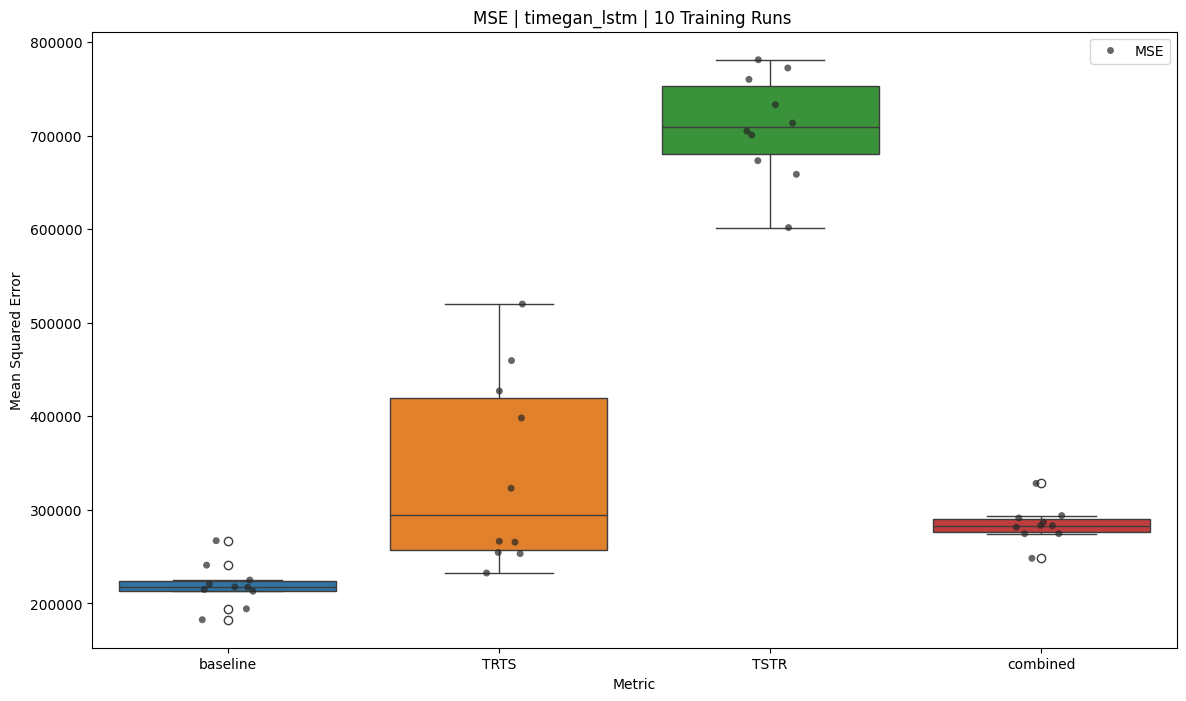

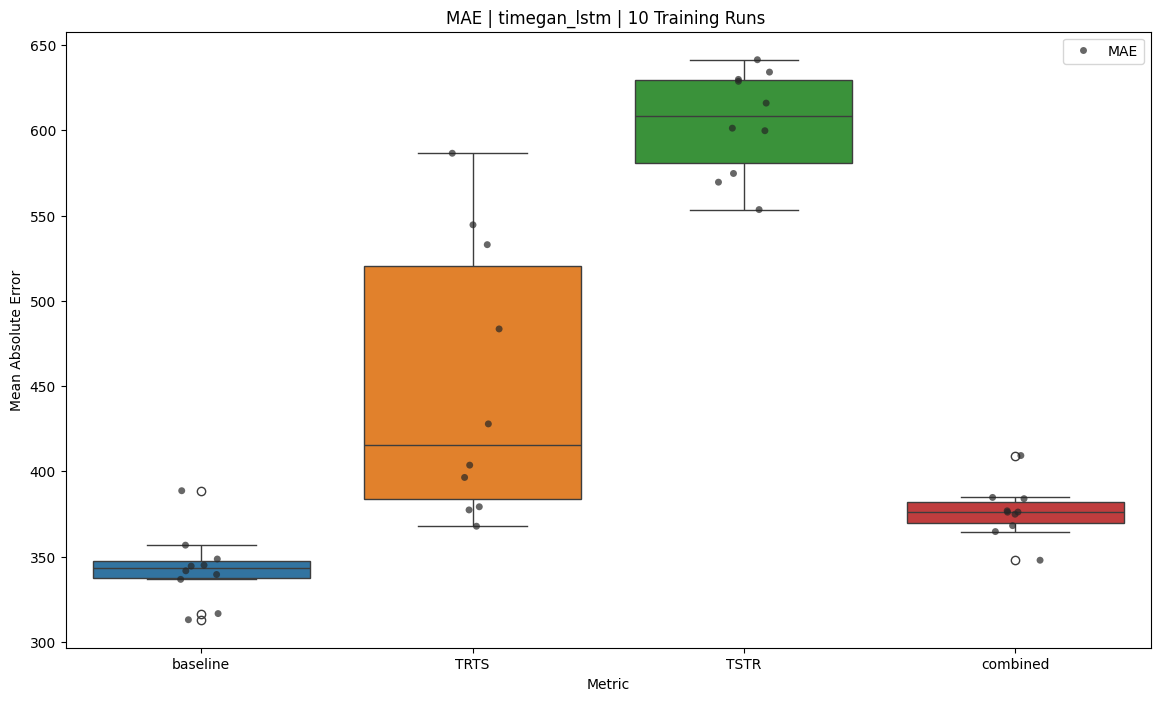

In [10]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [11]:
0.2*1e06

200000.0